In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  # for lemmatization
import time
import os
import json
import pickle
from gensim.models import Word2Vec
import pandas as pd

# import required libraries
import numpy as np
from numpy.linalg import norm
 
nltk.download('stopwords')
nltk.download('wordnet')
wordnet=WordNetLemmatizer()
stop_words=stopwords.words('english')+['com','http','https']

def text_preprocess(text):
    x=re.sub(r'http\S+','',text)  # Removing the URLs
    x=re.sub(r'@\S+','',x)        # Removing the twitter handle
    x=re.sub('[^a-zA-Z]',' ',x)   # only keeping the text
    x=x.lower().split()  # Tokenizing the text by sentence
    x=[wordnet.lemmatize(word) for word in x if word not in stop_words and len(word)>1] # Lemmatize the wordnet
    #x=' '.join(x)
    return x

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def tweet_streaming():
    path=r"/home/ubuntu/new_mongo"
    list_dir=os.listdir(path)
    tweets={}
    tweets['text']=[]
    for i in list_dir: 
        new_path=os.path.join(path,i)
        f=open(new_path,'r')
        file=json.load(f)
        f.close()
        for i in file['results']:
            row={}
            twt=''
            twt=text_preprocess(i['text'])
            if len(twt)>3:
                row['tweet_text']=str(twt)
                tweets['text'].append(twt)
                #print(twt)
            #print(row)  # From Here we need to put the sentiment part into mongo db
      
    return tweets

In [4]:
def transform(w2v_model,data):
    n=len(model.wv[0])
    m=len(data)
    vec=[]
    for i in data:
        count=0
        temp=np.zeros(n)
        for j in i:
            if j in w2v_model.wv:
                temp+=w2v_model.wv[j]
                count+=1
            else:
                continue
        if count!=0:
            vec.append(temp/count)  
        else:
            vec.append(temp)
    return np.array(vec)

In [5]:
def topic_identification(topic_vector,data_vector):
    topics=list(topic_vector.keys())
    topic_mapping=[]
    for i in data_vector: 
        A=i
        max_topic=topics[0]
        max_cosine=0
        for j in topics:
            B=topic_vector[j]
            cosine = np.dot(A,B)/(norm(A)*norm(B))
            if cosine>max_cosine:
                max_topic=j
                max_cosine=cosine
            else:
                continue
        topic_mapping.append(max_topic)
            # compute cosine similarity
    return topic_mapping

In [6]:
f=open("topic_vector.json",'r')
topic_vector=json.load(f)

In [7]:
model_path=r"/home/ubuntu/Tstreaming/models/word2vec_2sw.model"
model=Word2Vec.load(model_path)

dt_path="/home/ubuntu/Tstreaming/models/decision_tree_dft_w2v_2swd.pkl"
dt = pickle.load(open(dt_path, 'rb'))

/home/ubuntu/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
def plotting(label,value):
    import matplotlib.pyplot as plt
    # to generate a list of 16 rows

    # to plot 4x4 images
    fig,axs=plt.subplots(nrows=2, ncols=3,figsize=(10,10))

    i=0;
    # Reshape 4x4 matrix into vector inorder to make it iterable
    for ax in axs.reshape(-1):
        value=values[i:i+2]
        z=labels[i:i+2]
        label=['positive' if i[1]==1 else "negative" for i in z]
        if len(z)!=0:
            ax.set_title('Topic: %s'%z[0][0]) 
        #imshow is flag that is used in matshow wrapper
        ax.pie(value,labels=label,autopct='%1.0f%%')
        #ax.imshow(pixel_mat(axs_idx[i]),cmap=plt.cm.gray, origin='upper',interpolation=
              #'nearest')
        ax.axis('off')
        i+=2;
    # tight layout gives more spacing between subplots
    plt.tight_layout()
    # To plot all the previously generated object
    plt.show()

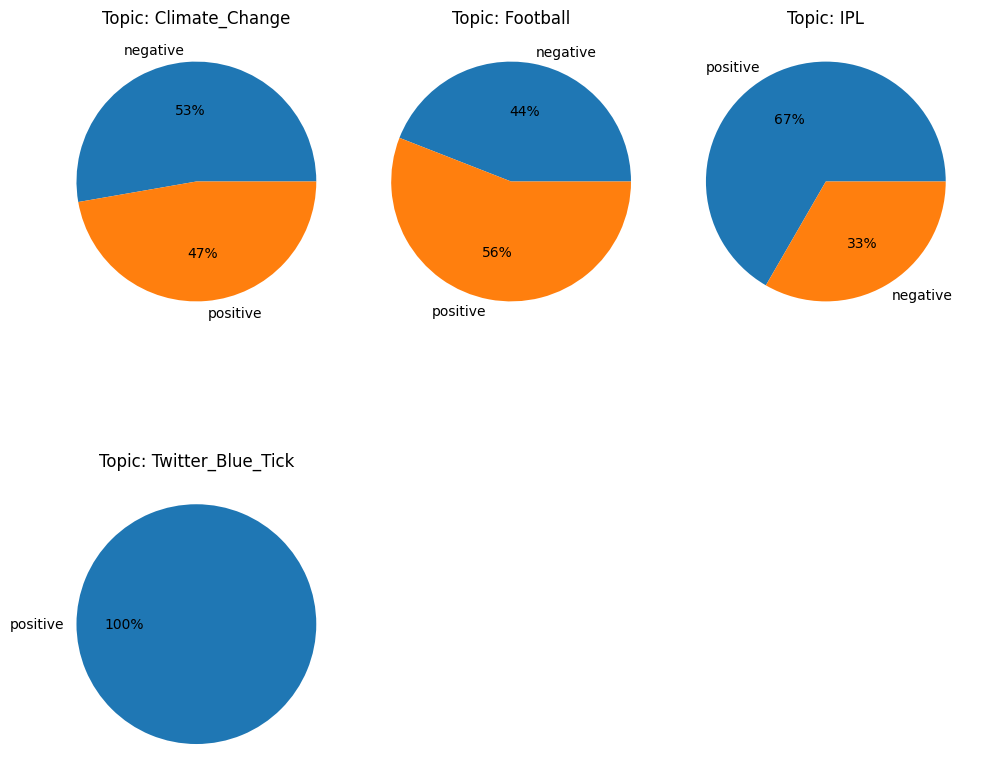

Updated Frame: 1


In [11]:
import datetime
count=0
while(count<1):
    count=count+1
    tweets=tweet_streaming()
    data=transform(model,tweets['text'])
    topic_map=topic_identification(topic_vector,data)
    y_pred=dt.predict(data)
    z={'topic':topic_map, 'tweet_text':tweets['text'],'Sentiment':list(y_pred)}
    ddf=pd.DataFrame(z)
    p=ddf.groupby(by=['topic','Sentiment'])['Sentiment'].count()
    k=dict(p)
    labels=list(k.keys())
    values=[]
    for i in k.keys():
        values.append(k[i])
    plotting(labels,values)
    print('Updated Frame:',count)
    count+1
    time.sleep(60)
    